In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path

import numpy as np
import arviz
import theano
import pymc3 as pm

from sklearn.preprocessing import scale

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
# model_path = Path('models')
sns.set_style('whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


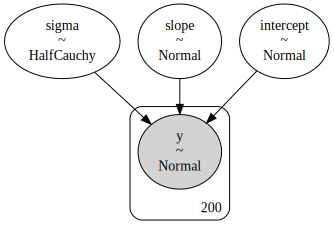

In [2]:
# Artificial Data
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
true_regression_line = true_intercept + true_slope * x
y = true_regression_line + np.random.normal(scale=.5, size=size)

x_shared = theano.shared(x)
# Model Definition
with pm.Model() as linear_regression: # model specification

    # Define priors
    sd = pm.HalfCauchy('sigma', beta=10, testval=1) # unique name for each variable
    intercept = pm.Normal('intercept', 0, sd=20)
    slope = pm.Normal('slope', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * x_shared, sd=sd, observed=y)
pm.model_to_graphviz(linear_regression)

In [6]:
with linear_regression:
    # Inference
    trace = pm.sample(draws=2500, # draw 2500 samples from posterior using NUTS sampling
                      tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [slope, intercept, sigma]


Sampling 2 chains for 1_000 tune and 2_500 draw iterations (2_000 + 5_000 draws total) took 5 seconds.


In [7]:
arviz.plot_posterior(trace);

Got error No model on context stack. trying to find log_likelihood in translation.

KeyboardInterrupt



Error in callback <function flush_figures at 0x000001E05BCBBC10> (for post_execute):



KeyboardInterrupt



In [8]:
prices = yf.download('GFI GLD', period='max').dropna().loc[:, 'Close']

[*********************100%***********************]  2 of 2 completed


In [9]:
returns = prices.pct_change().dropna()
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4740 entries, 2004-11-18 to 2023-09-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GFI     4740 non-null   float64
 1   GLD     4740 non-null   float64
dtypes: float64(2)
memory usage: 111.1 KB


In [10]:
prices_normed = prices.apply(scale)

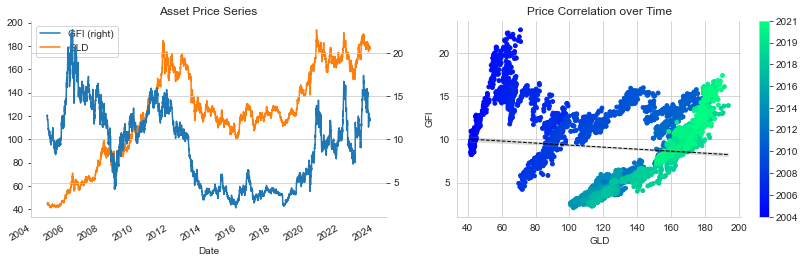

In [11]:
fig, axes= plt.subplots(figsize=(14,4), ncols=2)

prices.plot(secondary_y='GFI', ax=axes[0])
axes[0].set_title('Asset Price Series')
points = axes[1].scatter(prices.GLD, prices.GFI, c=np.linspace(0.1, 1, len(prices)), s=15, cmap='winter')
axes[1].set_title('Price Correlation over Time')
cbar = plt.colorbar(points, ax=axes[1])
cbar.ax.set_yticklabels([str(p.year) for p in returns[::len(returns)//10].index]);

sns.regplot(x='GLD', y='GFI', data=prices, scatter=False, color='k',
            line_kws={'lw':1, 'ls':'--'}, ax=axes[1])
sns.despine()

In [12]:
with pm.Model() as model_reg:
    pm.glm.GLM.from_formula('GFI ~ GLD', prices)
    trace_reg = pm.sample(draws=5000, tune=1000, cores=1)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, GLD, Intercept]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8977419677633627, but should be close to 0.8. Try to increase the number of tuning steps.


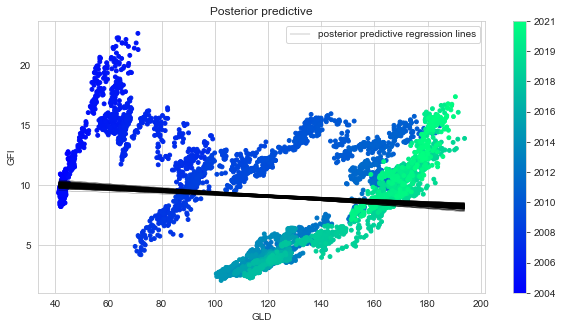

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, xlabel='GLD', ylabel='GFI', title='Posterior predictive regression lines')
points = ax.scatter(prices.GLD, prices.GFI, c=np.linspace(0.1, 1, len(prices)), s=15, cmap='winter')

pm.plot_posterior_predictive_glm(trace_reg[100:], samples=250, label='posterior predictive regression lines', lm=lambda x, sample: sample['Intercept'] + sample['GLD'] * x,
                                 eval=np.linspace(prices.GLD.min(), prices.GLD.max(), 100))
cb = plt.colorbar(points)
cb.ax.set_yticklabels([str(p.year) for p in prices[::len(prices)//10].index]);
ax.legend(loc=0);

In [14]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 50.)
    alpha = pm.GaussianRandomWalk('alpha', sd=sigma_alpha, shape=len(prices))

    sigma_beta = pm.Exponential('sigma_beta', 50.)
    beta = pm.GaussianRandomWalk('beta', sd=sigma_beta, shape=len(prices))

with model_randomwalk:
    # Define regression
    regression = alpha + beta * prices_normed.GLD

    # Assume prices are normally distributed
    # Get mean from regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y', mu=regression, sd=sd, observed=prices_normed.GFI)

with model_randomwalk:
    trace_rw = pm.sample(tune=2000, draws=200, cores=1, target_accept=.9)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, sigma_beta, alpha, sigma_alpha]


Sampling 2 chains for 2_000 tune and 200 draw iterations (4_000 + 400 draws total) took 1601 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


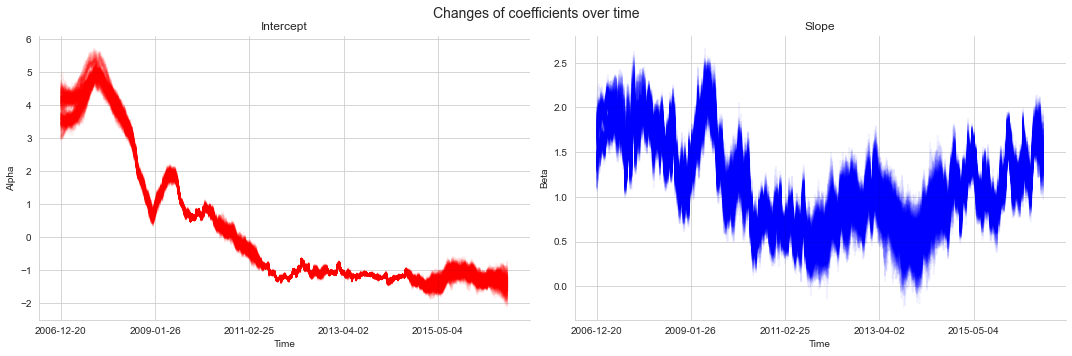

In [15]:
# Analysis of results
fig, axes = plt.subplots(figsize=(15, 5), ncols=2, sharex=True)

axes[0].plot(trace_rw['alpha'].T, 'r', alpha=.05)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Alpha')
axes[0].set_title('Intercept')
axes[0].set_xticklabels([str(p.date()) for p in prices[::len(prices)//9].index])

axes[1].plot(trace_rw['beta'].T, 'b', alpha=.05)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Beta')
axes[1].set_title('Slope')

fig.suptitle('Changes of coefficients over time', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

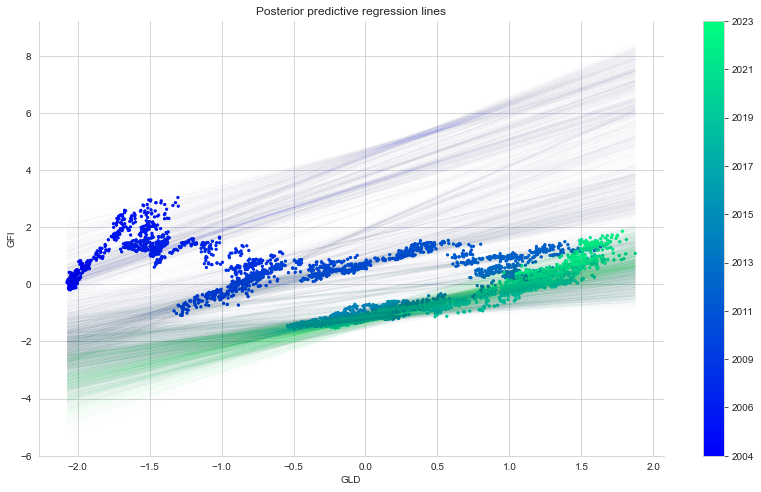

In [16]:
x = np.linspace(prices_normed.GLD.min(), prices_normed.GLD.max())

dates = [str(p.year) for p in prices[::len(prices)//9].index]

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[::10]['alpha'].T))

cmap = plt.get_cmap('winter')
fig, ax = plt.subplots(figsize=(14, 8))

for i, (alpha, beta) in enumerate(zip(trace_rw[::25]['alpha'].T,
                                      trace_rw[::25]['beta'].T)):
    for a, b in zip(alpha[::25], beta[::25]):
        ax.plot(x, a + b*x, alpha=.01, lw=.5, c=cmap(colors_sc[i]))

points = ax.scatter(prices_normed.GLD, prices_normed.GFI, c=colors, s=5, cmap=cmap)

cbar = plt.colorbar(points)
cbar.ax.set_yticklabels(dates);

ax.set_xlabel('GLD')
ax.set_ylabel('GFI')
ax.set_title('Posterior predictive regression lines')
sns.despine()